In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input,plot_comparison

from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx

(CVXPY) Dec 03 08:05:50 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)")


In [4]:
N = 30
tf = 5
delT = tf/N

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
# H1 = get_H_obs(0.75,1.5)
H1 = get_H_obs(1.2,2.3)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
# H2 = get_H_obs(0.75,1.5)
H2 = get_H_obs(1.2,2.3)
c_list.append(c2)
H_list.append(H2)

In [7]:
myModel = UnicycleModel.unicycle1('unicycle','numeric_central')

ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

In [8]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
Qf = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

In [9]:
A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 1*np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

In [10]:
x_max = np.array([10,10,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

traj_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

x_max = np.array([1,1,np.pi])
x_min = np.zeros(ix)

u_max = np.array([5,5]) 
u_min = np.zeros(iu)

funl_scaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [14]:
traj_solver= trajopt('unicycle',N,tf,20,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)

Is DPP?  True


In [15]:
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)

┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │6249.082   │5.000     │32.3     │0          │-6.25e+03   │0(0.79  )│0(1.676 )│0(1.966 )│
│2     │312.297    │5.000     │161      │0          │5.94e+03    │1(-13.03)│0(15.154)│0(0.370 )│
│3     │241.245    │5.000     │159      │0          │71.1        │1(-10.35)│0(8.250 )│0(0.423 )│
│4     │150.781    │5.000     │138      │0          │90.5        │1(-14.14)│0(1.237 )│0(0.109 )│
│5     │140.844    │5.00

In [17]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.75,1.5)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
H2 = get_H_obs(0.75,1.5)
c_list.append(c2)
H_list.append(H2)

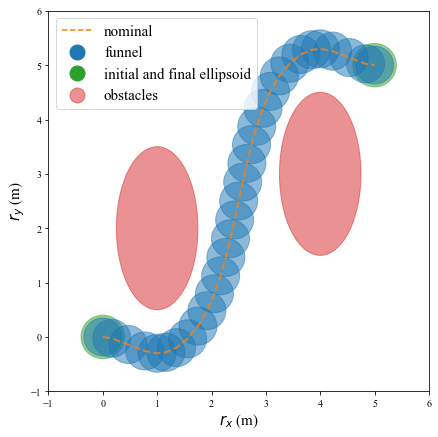

In [19]:
plt.figure(1,figsize=(7,7))
plt.rcParams["font.family"] = "Times New Roman"
plot_traj_set(xnom,unom,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
plt.savefig('../images/first_iteration/overestimation.pdf')
# plt.close()

In [20]:
myConst.set_obstacle(c_list,H_list)
traj_solver= trajopt('unicycle',N,tf,20,myModel,myCost,myConst,Scaling=traj_scaling,
              w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,tol_dyn=1e-3,verbosity=True)
_,_,xnom,unom,_,total_num_iter,_,_,_,_,history_nom = traj_solver.run(x0,u0,xi,xf)

Is DPP?  True
┌──────────────────────────────────────────────────────────────────────────────────────────────┐

│                                              ..:: SCP ::..                                   │

├──────┬───────────┬──────────┬─────────┬───────────┬────────────┬─────────┬─────────┬─────────┤

│ iter │  total    │ final    │ input   │     -     │ total cost │ vc      │ tr      │ dyn     │

│      │  cost     │ time [s] │ energy  │     -     │ reduction  │ (log10) │         │         │

├──────┼───────────┼──────────┼─────────┼───────────┼────────────┼─────────┼─────────┼─────────┤

│1     │5042.412   │5.000     │30       │0          │-5.04e+03   │0(0.70  )│0(1.238 )│0(0.634 )│
│2     │91.044     │5.000     │46.4     │0          │4.95e+03    │1(-14.11)│0(4.462 )│0(0.171 )│
│3     │79.420     │5.000     │68.1     │0          │11.6        │1(-14.43)│0(1.130 )│0(0.075 )│
│4     │74.255     │5.000     │72.5     │0          │5.16        │1(-12.80)│0(0.172 )│0(0.013 )│
│5     │74

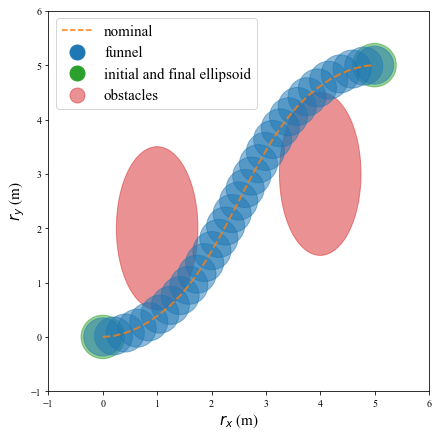

In [22]:
plt.figure(1,figsize=(7,7))
plot_traj_set(xnom,unom,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt,flag_label=True)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig('../images/first_iteration/underestiatmion.pdf')
# plt.close()